# Table of Contents
* [1. Introduction](#1.-introduction)
* [2. Ensuring that you have the necessary packages to go through this tutorial](#2.-ensuring-that-you-have-the-necessary-packages-to-go-through-this-tutorial)
* [3. Initializing a system - FCC lattice](#3.-initializing-a-system---fcc-lattice)
    * [3-1. Building an FCC unit cell using custom python scripts](#3-1.-building-an-fcc-unit-cell-using-custom-python-scripts)
    * [3-2. Building an FCC unit cell using freud Data Module](#3-2.-building-an-fcc-unit-cell-using-freud-data-module)
    * [3-3. Comparing the two initialization methods](#3-3.-comparing-the-two-initialization-methods)
* [4. Set-up for HOOMD-blue simulation (Hard Particle)](#4.-set-up-for-hoomd-blue-simulation-hard-particle)

## 1. Introduction

The purpose of this notebook is to provide a starting place for running HOOMD-blue molecular dynamics simulations. It is recommended that you read the official HOOMD-blue tutorial (<https://hoomd-blue.readthedocs.io/en/v3.0.1/tutorial/01-Introducing-Molecular-Dynamics/01-Molecular-Dynamics-Simulations.html>) that contains some basic information that can help you to understand the basic set-up of the simulation scripts before going through this notebook. This document will hopefully help you to remember and get more familiar with the HOOMD-blue classes/functions and Python syntax to use them.


## 2. Ensuring that you have the necessary packages to go through this tutorial

Going through this notebook will require you to have certain Python packages installed on your machine. Assuming you have them set-up within your conda environment, activate the environment and check for the packages with `conda list | grep "hoomd\|freud\|gsd\|matplotlib"`.

The output should resemble the following:

|  |  |  |  |
| --- | --- | --- | --- |
| freud | 2.8.0 | py310he7ab2d0_0 | conda-forge |
| gsd | 2.5.2 | py310h7f5fb2b_0 | conda-forge |
| hoomd | 3.0.0 | cpu_py310h89b14bd_1 | conda-forge |
| matplotlib | 3.5.1 | py310hecd8cb5_1 |  |
| matplotlib-base | 3.5.1 | py310hfb0c5b7_1 |  |
| matplotlib-inline | 0.1.2 | pyhd3eb1b0_2 |  |

Unless there is a major version difference ex. V2.x.x vs V3.x.x, there shouldn't be a difference in the syntax, so don't worry about minor details of the output. If there has been a major version change for any of the packages, please raise an issue on the github repository for it to be updated.

If all four packages are installed, start up an interactive Python session with `python` and type the following for the basic functions of the simulation to ensure that your packages are functioning correctly without conflicts.

```python
import hoomd, freud, gsd.hoomd, matplotlib.pyplot as plt
hoomd.device.CPU()
freud.Box.cube(10)
gsd.hoomd.Snapshot()
plt.figure()
```

If all works without any error, proceed to the next section. If not, you may need to reinstall the malfunctioning packages.


## 3. Initializing a system - FCC lattice

There are a few ways to initialize a molecular dynamics system. For example, to create an FCC lattice, you can choose from:

1. custom python script to provide molecule positions
2. freud unit cell functions
3. other specialized packages as suggested by HOOMD-blue developers
    * mbuild (<https://mbuild.mosdef.org/en/stable/>)
    * Foyer (<https://foyer.mosdef.org/en/stable/>)

This notebook will focus on using the first two options.


### 3-1. Building an FCC unit cell using custom python scripts

The process is broken down to the following:

1. Define the system properties
    1. particle size
    2. density
    3. dimension of the simulation box (x:y:z)
2. Define a unit cell from the given parameters
3. clone the unit cell to produce coordinate points
4. output a gsd snapshot to be called into HOOMD-blue

See below for a code block that generates an FCC lattice snapshot with 20000 particles with diameter of 1.0 and Lennard-Jones potential with epsilon of 6 kT, system density of 0.60, and box dimensions of (x:y:z=1:1:1). This assumes hard-particle-potential and adjusts the particle diameter to the effective particle diameter of &sigma; &cross; r<sub>cut</sub> as well as a buffer.


In [3]:
import numpy as np
import hoomd
import gsd.hoomd

############### system parameters ###############
N = int(20000) # number of particles
r_cut = 2 ** (1/6)
sigma = float(1.0 * r_cut) # particle diameter
phi = float(0.60) # system density
boxDim = np.array([1,1,1,0,0,0], dtype=int) # simulation box dimensions

############### derived parameters ###############
partVol = float(np.pi * (sigma) ** 3 / 6) # volume of a single particle
totPartVol = float(partVol * N) # volume of all particles
boxVol = float(totPartVol / phi) # volume of the simulation box with the given system density
targetBox = boxDim * (boxVol / np.prod(boxDim[0:3])) ** (1 / 3) # box configuration

############### initiate a gsd snapshot ###############
snapshot = gsd.hoomd.Snapshot() # define a snapshot
snapshot.particles.N = N
snapshot.particles.types=['A'] # add a single species of particles

############### calculate number of unit cell repeat ###############
cellSideLen = sigma * ((2 * np.pi) / (3 * phi)) ** (1/3) # unit cell side length
repeatTestVal = np.floor((targetBox * 1.1 / cellSideLen)).astype('int64') # number of cells on each side
uCellRepeat = repeatTestVal if 4 * np.prod(repeatTestVal[0:3]) >= N \
              else np.ceil((targetBox * 1.1 / cellSideLen)).astype('int64') # test if the number of cells was an underestimate, and if so, overestimate
temp = ( # template unit cell with a corner at the origin
    np.array([0, 0, 0]),
    np.array([cellSideLen/2, cellSideLen/2, 0]),
    np.array([cellSideLen/2, 0, cellSideLen/2]),
    np.array([0, cellSideLen/2, cellSideLen/2])
)

cellLengths = cellSideLen * (uCellRepeat+[1, 1, 1, 0, 0, 0]) #overestimate the box dimensions to ensure all particles are within the box
snapshot.configuration.box = cellLengths

############### iterate over the number of repeat and populate position array ###############
pos = []
for i in range(uCellRepeat[0]): # loop over the first dimension
    for j in range(uCellRepeat[1]): # loop over the second dimension
        for k in range(uCellRepeat[2]): # loop over the third dimension
            currentLoc = np.array([ # translation vector
                -uCellRepeat[0] * cellSideLen/2 + i * cellSideLen,
                -uCellRepeat[1] * cellSideLen/2 + j * cellSideLen,
                # -uCellRepeat[2] * cellSideLen/2 + k * cellSideLen
            ])
            for l in temp: # append each position value after translation
                pos.append(l[0:1]+currentLoc)
                if len(pos) == N: # only up to the given particle number
                    break
            if len(pos) == N: # only up to the given particle number
                break
        if len(pos) == N: # only up to the given particle number
            break
    if len(pos) == N: # only up to the given particle number
        break

snapshot.particles.position = pos # set particle positions

############################################################
###############         Visualization        ###############
#!---        NOT needed for your initialization        ---!#
#!--- this part is just to show the initialized system ---!#
############################################################
import fresnel

scene = fresnel.Scene()
geometry = fresnel.geometry.Sphere(scene, N=snapshot.particles.N, radius=sigma/2)
geometry.position[:] = snapshot.particles.position
fresnel.geometry.Box(scene, snapshot.configuration.box, box_radius=0.07)
scene.camera = fresnel.camera.Orthographic.fit(scene)
fresnel.preview(scene)


ValueError: could not broadcast input array from shape (20000,2) into shape (20000,3)

Note that the generated lattice is not a perfectly symmetrical cuboid nor the system density is currently at the given system density. Because each FCC unit cell has 4 particles, you will get a perfect cuboid if and only if your system has 4 &cross; &#8469;<sup>3</sup> particles. Also, the current script calculates the box volume from the overestemated number of particles to ensure the particles don't overlap over the periodic boundary. This box size can be adjusted to the target values during a HOOMD-blue simulation by doing a passive Brownian run with a gradual box size reduction. This could be done during a randomization (equilibration) run.

### 3-2. Building an FCC unit cell using freud Data Module

Using frued requires less creativity as it automates the process. Refer to <https://freud.readthedocs.io/en/latest/modules/data.html?highlight=fcc#freud.data.UnitCell.fcc> for the documentation on the unit cell functions.


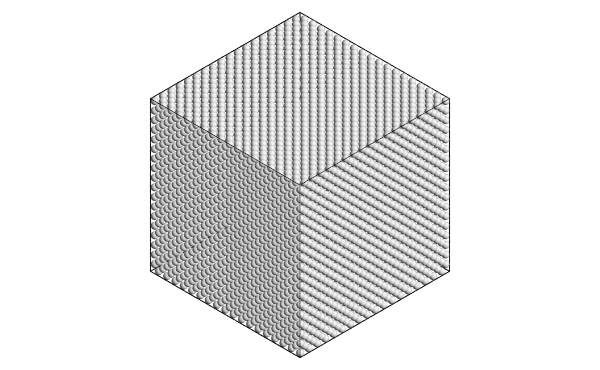

In [ ]:
import freud.data

##### Using the parameters defined above #####
cell = freud.data.UnitCell.fcc() # define an FCC unit cell
box, positions = cell.generate_system(scale=cellSideLen,num_replicas=int(np.ceil((N/4)**(1/3)))) # get 

############### define a new snapshot ###############
snapshot_freud = gsd.hoomd.Snapshot()
snapshot_freud.particles.N = N
snapshot_freud.configuration.box = [box.to_matrix()[0,0], box.to_matrix()[1,1], box.to_matrix()[2,2], 0, 0, 0]
snapshot_freud.particles.position = positions[0:N]

############################################################
###############         Visualization        ###############
#!---        NOT needed for your initialization        ---!#
#!--- this part is just to show the initialized system ---!#
############################################################
import fresnel

scene_freud = fresnel.Scene()
geometry = fresnel.geometry.Sphere(scene_freud, N=snapshot_freud.particles.N, radius=sigma/2)
geometry.position[:] = snapshot_freud.particles.position
fresnel.geometry.Box(scene_freud, snapshot_freud.configuration.box, box_radius=0.07)
scene_freud.camera = fresnel.camera.Orthographic.fit(scene_freud)
fresnel.preview(scene_freud)


Note that particle indexing is different from the python script above. Also, the box size is scaled to fit a perfect lattice of 4 &cross; (18)<sup>3</sup> &equals; 23328 particles (which is the same size as the one from the script above). freud also has the capability to initialize a lattice with BCC, hexagonal, simple cubic, and square unit cells as well as the capability to initialize a random system. Beware that there is no parameter that checks for particle overlap, so if the particles are close enough to experience a large repulsive force, they may fly out of the simulation box and your simulation may fail.

### 3-3. Comparing the two initialization methods

#### Custom Script

The advantages of using a custom script are that

1. you know exactly what is going on with the initialization process and thus can predict/correct the initialization behaviors
2. you can define more than the basic lattices provided by the software packages

and the disadvantages are that

1. you need to make your own script
2. upon syntax change, you need to maintain and update the code yourself.

#### freud Data Module

The advantages of using freud Box Module are that

1. It's ready to use and does not require you to program anything other than learning the syntax
    1. FCC
    2. BCC
    3. Hexagonal
    4. Simple Cubic
    5. Square
    6. Random
2. It's legitimacy and functionality is backed by a group of known developers (A few from HOOMD-blue development team)
3. It is most likely to be updated to (what the developers view as) the current standard, and you won't need to deal with any changes or updates yourself

and the disadvantages are that

1. You don't exactly know what's going on behind the scene until you examine the source code <https://github.com/glotzerlab/freud/blob/master/freud/data.py>
2. It may lag behind what you view as the current standards
3. It may not be supported in the future updates.


## 4. Set-up for HOOMD-blue simulation (Hard Particle)
The following section will discuss how to set-up and start a HOOMD-blue simulation from the generated snapshot. The particles will interact via a hard-particle-potential (WCA potential). This process is broken down as the following:

1. Define system parameters
2. Instantiate the simulation object
3. Define particle interactions
4. Equilibrate (position randomization, box resizing)
5. Running the simulation


In [ ]:
import hoomd
import numpy as np
from random import randint
import datetime

############### define a custom operation that will update us with the simulation status ###############
class printSimState(hoomd.custom.Action):
    def act(self, timestep):
        try:
            secRemaining = int((self._state._simulation.final_timestep - timestep) / self._state._simulation.tps)
        except ZeroDivisionError:
            secRemaining = 0
        print(
            "Time step:", timestep,
            "| TPS:", self._state._simulation.tps,
            "| ETR:", str(datetime.timedelta(seconds=secRemaining))
        )

############### define system parameters ###############
system = snapshot
simRunTime = 10 # number of Brownian time steps to run
kT = 1.0 # normalized system energy
sigma = 1.0 # particle size
threeEtaPi = 1.0 / sigma # drag
D_t = kT / (threeEtaPi * sigma) # Diffusion constant
D_r = (3.0 * D_t) / (sigma ** 2) # Rotational diffusion constant
T_B = (sigma ** 2) / D_t # Brownian Tau
r_cut = 2 ** (1/6)
eps = 10 # well depth
dt = 1e-6 # time step size
seedRun = randint(0, 32767) # random seed for the simulation run picked from all possible unsigned int

############### initialize the system ###############
device = hoomd.device.auto_select() # auto select the device to run on: CPU/GPU
if isinstance(device, hoomd.device.CPU): # if CPU, utilize threaded run
    device.num_cpu_threads=8
sim = hoomd.Simulation(device=device, seed=seedRun) # define the simulation object
sim.create_state_from_snapshot(snapshot) # initialize with the snapshot

############### print system variables before initializing a hoomd simulation##########
print("System Variables")
print("="*30)
print("N:", str(N))
print("Particle size (diameter):", str(sigma))
print("Cutoff radius for LJ potential (sigma):",str(r_cut))
print("phi:", str(phi))
print("Epsilon:", str(eps))
print("dt:", str(dt))
print("Seed for simulation run:", str(seedRun))
print("Simulation device:", device)
print("Number of TBB threads:", device.num_cpu_threads)
print("="*30)
print("Starting Simulation")
print("="*30)

############### equilibrate the system and resize the simulation box ###############
cell = hoomd.md.nlist.Cell(buffer=r_cut) # define a cell list for neighbor calculation
lj = hoomd.md.pair.LJ(nlist=cell) # define the LJ potential
lj.params[('A', 'A')] = dict(epsilon=eps, sigma=sigma) # assign the defined parameters
lj.r_cut[('A', 'A')] =r_cut # set the cutoff distance to 2 ** (1/6) to get WCA potential (hard particles)
sim.operations.integrator = hoomd.md.Integrator( # define the MD integrator with the defined potential
    dt=dt,
    methods=[
        hoomd.md.methods.Brownian( # use Brownian integrator for equilibration
            filter=hoomd.filter.All(), # apply to all particles
            kT=100*kT, # run at higher temperature for faster equilibration
            alpha=threeEtaPi # drag
        )
    ],
    forces=[lj] # interparticle forces
)
custom_action = printSimState() # now the simulation can print status
custom_op = hoomd.write.CustomWriter(
    action=custom_action,
    trigger=hoomd.trigger.Periodic(int(1000)) # every 1000 steps
)
sim.operations.writers.append(custom_op)
final_box = hoomd.Box.from_box(targetBox) # define box resizing updater
final_box.volume = boxVol # resize to the target box volume
box_resize = hoomd.update.BoxResize(
    box1=sim.state.box,
    box2=final_box,
    variant=hoomd.variant.Ramp(
        A=0,
        B=1,
        t_start=sim.timestep,
        t_ramp=10000
        ),
    trigger=hoomd.trigger.Periodic(10)
)
sim.operations.updaters.append(box_resize)
sim.run(2 * int(0.01 * dt ** (-1))) # run the simulation for 0.02 Brownian Taus

############### run the simulation with Langevin integrator ###############
sim.operations.integrator.methods.append( # define the Langevin integrator
    hoomd.md.methods.Langevin(
        filter=hoomd.filter.All(),
        kT=kT, # use the normalized energy for the actual simulation
        alpha=threeEtaPi
    )
)
gsd_writer = hoomd.write.GSD( # define the writer to save the simulation run
    filename='simRun.gsd',
    trigger=hoomd.trigger.Periodic(1000),
    mode='wb',
    filter=hoomd.filter.All()
)
sim.operations.writers.append(gsd_writer)
sim.run(3 * int(0.01 * dt ** (-1))) # run the simulation for 0.03 Brownian Taus
print("="*30)
print("Finished running the simulation")


System Variables
N: 20000
Particle size (diameter): 1.0
Cutoff radius for LJ potential (sigma): 1.122462048309373
phi: 0.6
Epsilon: 10
dt: 1e-06
Seed for simulation run: 4542
Simulation device: <hoomd.device.CPU object at 0x7fc8040d0a00>
Number of TBB threads: 8
Starting Simulation
Time step: 1000 | TPS: 90.12859970830452 | ETR: 0:03:30
Time step: 2000 | TPS: 93.7361684640112 | ETR: 0:03:12
Time step: 3000 | TPS: 94.95124685646151 | ETR: 0:02:59
Time step: 4000 | TPS: 95.13740336648425 | ETR: 0:02:48
Time step: 5000 | TPS: 95.07248026166747 | ETR: 0:02:37
Time step: 6000 | TPS: 94.55734450569577 | ETR: 0:02:28
Time step: 7000 | TPS: 93.93410359566703 | ETR: 0:02:18
Time step: 8000 | TPS: 93.28792069423473 | ETR: 0:02:08
Time step: 9000 | TPS: 92.74307063227339 | ETR: 0:01:58
Time step: 10000 | TPS: 92.09704643141814 | ETR: 0:01:48
Time step: 11000 | TPS: 91.78235041006032 | ETR: 0:01:38
Time step: 12000 | TPS: 91.50147786439776 | ETR: 0:01:27
Time step: 13000 | TPS: 91.07458680064612 |

Note that if you have hoomd 3.0.0 instead of 3.0.1, the TPS and ETR calculation are not functioning correctly. As far as I know, it does not affect the simulation and the outputs.
You can update your HOOMD-blue simulation package with `conda install -c conda-forge -y hoomd=3.0.1`.
You can view the simulation trajectories from the saved .gsd file with OVITO <https://www.ovito.org/> and do additional analyses as the .gsd file contains particle velocity and the orientation at each saved time step.
You can also use different integrators such as NVT or add an active force to the particles.

```python
############### add active force ###############
t_R = D_r **(-1) # reorientation time
active = hoomd.md.force.Active(
    filter = hoomd.filter.All()
    active_force['A'] = (1,0,0)
    active_torque['A'] = (0,0,0)
)
sim.operations.append(
    active.create_diffusion_updater(
        trigger = t_R)
    )
)
```
